In [1]:
## personal imports
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from functional.backtester import Backtester as b
from transformer.adhoc_transforms import Adhoc as adhocs
from transformer.risk_transforms import Risk as risks
from transformer.analysis_transforms import Analysis as anas

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
market = Market()
strats = ["dividends","earnings","financials","sector"]

In [4]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [5]:
tyields = adhocs.tyields()
bench_returns = adhocs.spy_bench()

In [6]:
bench_returns.sort_values("date")

,date,adjclose,volume,open,high,low,year,quarter,week,day,bench_return,quarter_start,bench_quarterly_return,variance,quarterly_variance
2514,2013-06-03,164.350,167951300,163.83,164.46,162.6599,2013,2,23,0,-0.005507,160.42,0.018857,0.000142,0.000057
2513,2013-06-04,163.560,157443600,164.44,165.10,162.7300,2013,2,23,1,0.004830,160.42,0.024498,0.000138,0.000107
2512,2013-06-05,161.272,211143000,163.09,163.42,161.1300,2013,2,23,2,0.014187,160.42,0.019574,0.000145,0.000153
2511,2013-06-06,162.730,200028000,161.20,162.74,160.2500,2013,2,23,3,-0.008960,160.42,0.005311,0.000145,0.000247
2510,2013-06-07,164.800,185733300,163.85,164.95,163.1400,2013,2,23,4,-0.012561,160.42,0.014400,0.000146,0.000287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,2023-05-03,408.020,91531770,411.36,413.87,407.7700,2023,2,18,2,0.006911,420.02,-0.021856,0.000057,0.000077
16,2023-05-04,405.130,94901860,406.93,407.27,403.7400,2023,2,18,3,0.007134,420.02,-0.028570,0.000064,0.000092
15,2023-05-05,412.630,87891790,408.91,413.72,408.6400,2023,2,18,4,-0.018176,420.02,-0.035451,0.000064,0.000081
14,2023-05-08,412.740,50046770,412.97,413.24,411.2800,2023,2,19,0,-0.000267,420.02,-0.017594,0.000046,0.000052


In [7]:
speculation_db = ADatabase(f"all_financial")
speculation_db.connect()
t = speculation_db.retrieve("trades")
speculation_db.disconnect()

In [8]:
values = [True,False]
ceilings = [True,False]
parameters = []
positions = 10
for strat in strats:
    for value in values:
            for ceiling in ceilings:
                    parameter = {"value":value
                                 ,"ceiling":ceiling
                                ,"strat":strat
                                }
                    parameters.append(parameter)

In [9]:
analysis = []
indexer = list(parameters[0].keys())
for parameter in parameters:
    try:
        ledger = t.sort_values(["year","quarter"]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        if ledger.index.size > 0:
            cumulative = anas.quarterly_trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [10]:
a

,value,ceiling,strat,pv,beta,rrr,sharpe
7,True,True,dividends,2.138769,NaN,NaN,NaN
7,True,False,dividends,2.138769,NaN,NaN,NaN
7,False,True,dividends,2.138769,NaN,NaN,NaN
7,False,False,dividends,2.138769,NaN,NaN,NaN
7,True,True,earnings,1.729882,NaN,NaN,NaN
7,True,False,earnings,1.729882,NaN,NaN,NaN
7,False,True,earnings,1.729882,NaN,NaN,NaN
7,False,False,earnings,1.729882,NaN,NaN,NaN
7,True,True,financials,2.244481,NaN,NaN,NaN
7,True,False,financials,2.244481,NaN,NaN,NaN


In [11]:
a.sort_values("pv",ascending=False).groupby("strat").first().reset_index().sort_values("pv")

,strat,value,ceiling,pv,beta,rrr,sharpe
3,sector,True,True,1.226027,NaN,NaN,NaN
1,earnings,True,True,1.729882,NaN,NaN,NaN
0,dividends,True,True,2.138769,NaN,NaN,NaN
2,financials,True,True,2.244481,NaN,NaN,NaN


In [12]:
top = a.sort_values("pv",ascending=False).iloc[0]
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","quarter","ticker","projected_quarterly_return","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")

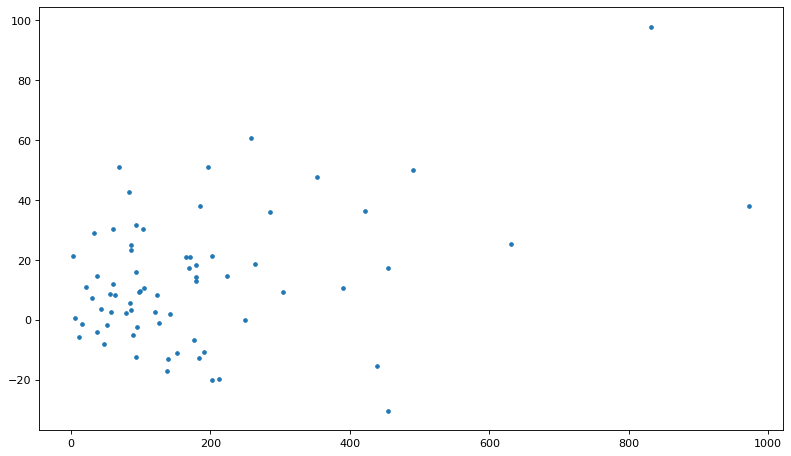

In [27]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger["projected_quarterly_return"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [29]:
ledger.sort_values("actual_returns",ascending=False)

,year,quarter,ticker,projected_quarterly_return,actual_returns,position,GICS Sector
8,2020,2,MRO,8.324322,1.978150,1,Energy
58,2020,2,DFS,2.576377,1.605690,8,Financials
62,2022,4,BA,0.683332,1.511226,8,Industrials
14,2022,4,PVH,1.968157,1.509528,1,Consumer Discretionary
23,2020,2,BBWI,4.911865,1.500585,3,Consumer Discretionary
...,...,...,...,...,...,...,...
7,2023,1,OGN,4.394220,0.847073,0,Health Care
59,2020,3,COP,1.373484,0.829569,8,Energy
15,2023,1,BAX,2.116524,0.803188,1,Health Care
22,2023,1,NLOK,2.025608,0.798357,2,Information Technology


In [14]:
portfolio = ledger.pivot_table(index=["year","quarter"],columns="position",values="actual_returns").fillna(1).reset_index()

In [15]:
portfolio

position,year,quarter,0,1,2,3,4,5,6,7,8,9
0,2020,2,1.379599,1.978150,1.252154,1.500585,1.362389,1.475741,1.093926,1.185262,1.605690,1.146005
1,2020,3,0.696106,1.105948,1.361184,0.891945,1.208635,1.172152,1.020134,0.869478,0.829569,1.026050
2,2020,4,1.130975,1.005847,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,2021,1,1.213737,1.378903,1.233248,1.426687,1.109288,0.986720,0.943233,1.213338,1.000000,1.000000
4,2021,2,1.083879,1.159894,1.055338,1.024487,1.086915,0.983722,0.920364,0.960235,1.144844,1.074369
5,2022,3,0.999186,1.181779,0.990739,1.096449,0.950935,1.083362,1.119591,1.302366,1.025606,1.035353
6,2022,4,1.173514,1.509528,1.144347,1.210203,1.106984,1.301777,1.092430,1.315202,1.511226,1.291354
7,2023,1,0.847073,0.803188,0.798357,0.873170,0.931791,0.888534,0.976124,0.876775,1.250027,1.031722


In [23]:
counted_columns = [x for x in range(positions)]
for i in counted_columns:
    if i not in portfolio.columns:
        portfolio[i] = 1
cumulative = portfolio[[i for i in counted_columns]].cumprod()
cumulative["date"] = [datetime(int(row[1]["year"]), 3*int(row[1]["quarter"]),1) for row in portfolio.iterrows()]
cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
bench = adhocs.spy_bench()
bench = bench.fillna(method="bfill")
cumulative = cumulative.merge(bench[["date","adjclose"]],on="date",how="left")
cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
cumulative = cumulative.fillna(method="bfill")

In [24]:
cumulative

,0,1,2,3,4,5,6,7,8,9,date,pv,adjclose,bench
0,1.379599,1.978150,1.252154,1.500585,1.362389,1.475741,1.093926,1.185262,1.605690,1.146005,2020-06-01,1.397950,305.55,1.000000
1,0.960347,2.187731,1.704411,1.338439,1.646630,1.729794,1.115951,1.030559,1.332031,1.175859,2020-09-01,1.422175,352.60,1.153985
2,1.086128,2.200523,1.704411,1.338439,1.646630,1.729794,1.115951,1.030559,1.332031,1.175859,2020-12-01,1.436032,366.02,1.197905
3,1.318273,3.034308,2.101962,1.909533,1.826587,1.706822,1.052602,1.250416,1.332031,1.175859,2021-03-01,1.670839,389.58,1.275012
4,1.428849,3.519476,2.218281,1.956292,1.985345,1.679038,0.968777,1.200694,1.524967,1.263306,2021-06-01,1.774503,419.67,1.373490
5,1.427686,4.159244,2.197739,2.144975,1.887934,1.819006,1.084634,1.563743,1.564015,1.307967,2022-09-01,1.915694,396.42,1.297398
6,1.675410,6.278493,2.514975,2.595854,2.089914,2.367941,1.184887,2.056638,2.363580,1.689049,2022-12-01,2.481674,407.38,1.333268
7,1.419195,5.042811,2.007846,2.266622,1.947363,2.103997,1.156597,1.803208,2.954538,1.742629,2023-03-01,2.244481,394.74,1.291900


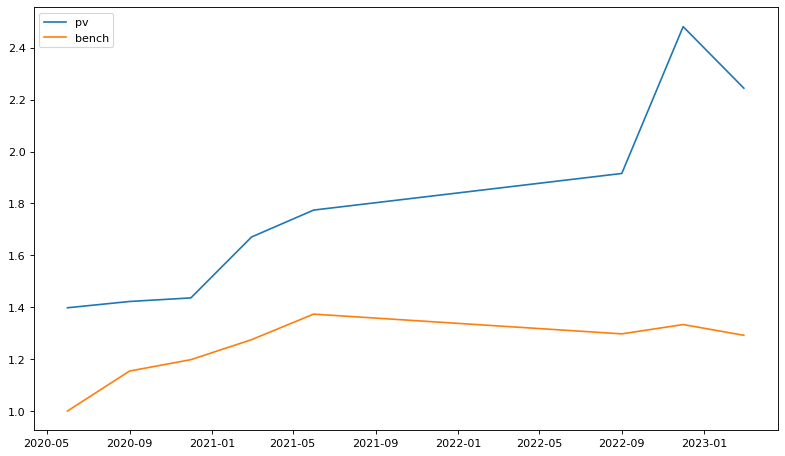

In [25]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

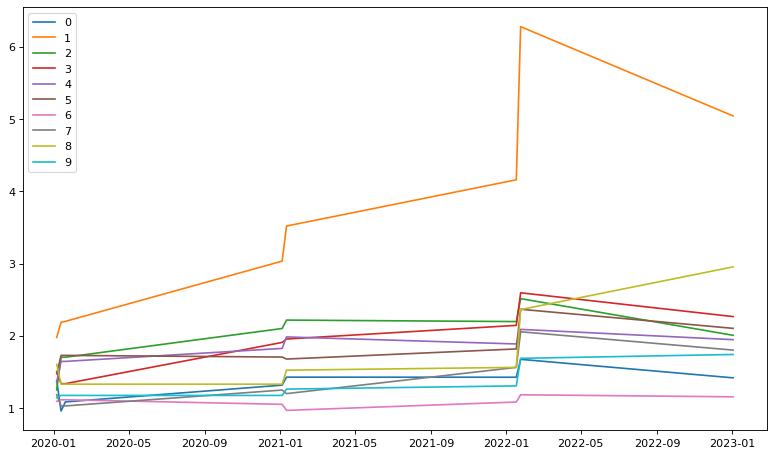

In [19]:
plt.figure(figsize=(12, 7), dpi=80)
for i in counted_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
    plt.legend(counted_columns)
plt.show()


In [20]:
ledger.groupby(["GICS Sector"]).mean().sort_values("projected_quarterly_return",ascending=False)

,year,quarter,projected_quarterly_return,actual_returns,position
GICS Sector,,,,,
Information Technology,2021.000000,1.833333,2.903583,1.052456,2.500000
Real Estate,2020.500000,2.000000,2.383666,1.224652,4.000000
Health Care,2022.166667,2.500000,2.369710,1.082706,2.000000
Energy,2020.750000,1.916667,2.068748,1.134563,4.000000
Consumer Discretionary,2021.538462,2.538462,1.721115,1.157802,3.384615
Materials,2021.200000,2.666667,1.702466,1.155978,4.866667
Financials,2021.222222,2.222222,1.386763,1.105059,5.888889
Communication Services,2021.000000,2.000000,0.851616,1.055338,2.000000
Industrials,2021.500000,3.000000,0.630433,1.124734,7.333333


In [21]:
industry_analysis = ledger.pivot_table(index=["year","quarter"],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,quarter,Communication Services,Consumer Discretionary,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate
0,2020,2,1.000000,1.488163,1.978150,1.375848,1.000000,1.000000,1.379599,1.177114,1.362389
1,4080400,6,1.000000,1.488163,1.625593,1.533223,1.000000,1.026050,1.525764,1.491012,1.362389
2,8242408000,24,1.000000,1.589970,1.625593,1.533223,1.000000,1.026050,1.525764,1.491012,1.362389
3,16657906568000,24,1.000000,1.589970,2.134637,1.533223,1.000000,0.967805,1.505502,1.731532,1.362389
4,33665629173928000,48,1.055338,1.708214,2.204235,1.508265,1.159894,0.967805,1.538709,1.773933,1.480801
5,-5715074105155790464,144,1.055338,1.817141,2.204235,1.671188,1.510607,0.956453,1.538709,1.836646,1.480801
6,-8218050482829006592,576,1.055338,2.743025,2.204235,1.671188,1.800430,1.340268,1.538709,2.189554,1.480801
7,-4599716350774329600,576,1.055338,2.833838,2.274158,1.475082,1.485590,1.340268,1.228439,2.040207,1.480801
